##### Import relevant libraries

In [70]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#### Read the files


In [71]:
stations = pd.read_csv('station.csv')
trips = pd.read_csv('trip.csv')

In [72]:
stations.head(1)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013


In [73]:
trips.head(1)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127


In [74]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int64
name                 70 non-null object
lat                  70 non-null float64
long                 70 non-null float64
dock_count           70 non-null int64
city                 70 non-null object
installation_date    70 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 4.0+ KB


In [75]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 11 columns):
id                    669959 non-null int64
duration              669959 non-null int64
start_date            669959 non-null object
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null object
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
dtypes: int64(5), object(6)
memory usage: 56.2+ MB


#### Preprocess the datasets

In [76]:
def total_trips():
    
        """ converts start and end date to pandas datetime object
         generates a day indicator (0 to 5) column
         generates a week/weekday indicator column
         output : total_trips dataframe"""
    
        # to datetime object
        trips['start_date'] = pd.to_datetime(trips['start_date'])
        trips['end_date'] = pd.to_datetime(trips['end_date']) 
    
        # day indicator column
        trips['day_week'] = trips['start_date'].dt.weekday
    
        # week/weekend indicator column
        week_indicator=[]
    
        for value in range(0,len(trips['duration'])):
            if trips.iloc[value]['day_week']<5:
                 week_indicator.append('week')
            else:
                week_indicator.append('weekend')   
        
        trips['week_indicator']= week_indicator
        
        # generate month indicator
        
        trips['Month'] = trips['start_date'].dt.month
        
        # generate hour indicator
        
        trips['Hour'] = trips['start_date'].dt.hour
        
        # generate year indicator
        
        trips['year'] = trips['start_date'].dt.year
        
        # generate column with duration in minutes
        
        trips['Duration_Minutes'] = trips['duration']/60
    
        return trips
        
        

In [77]:
total_trips = total_trips()

In [78]:
total_trips.head(1)   

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,day_week,week_indicator,Month,Hour,year,Duration_Minutes
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,week,8,14,2013,1.05


### Visualize distribution of Trips Duration

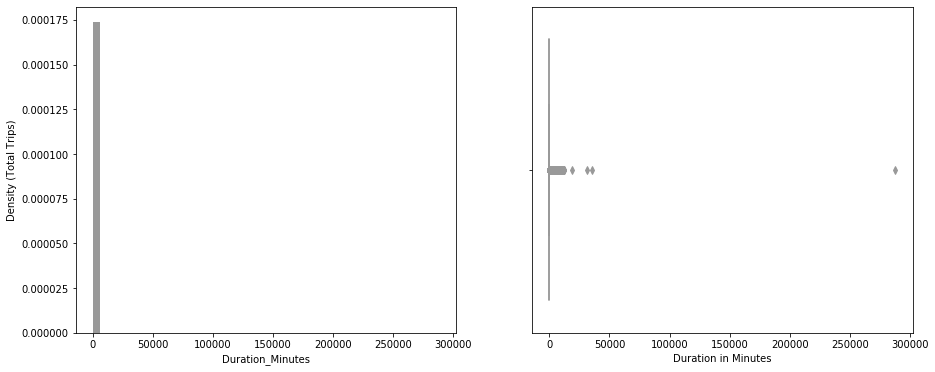

In [79]:
fig, ax= plt.subplots(1,2,figsize=[15,6])

sns.distplot(total_trips['Duration_Minutes'], kde=True, color=(0.0, 0.0, 0.0, 0.0),ax=ax[0])
ax[0].set_ylabel('Density (Total Trips)')
sns.boxplot(total_trips['Duration_Minutes'], ax=ax[1], color='white')
ax[1].set_xlabel('Duration in Minutes')

plt.savefig('Distribution_duration.png')

plt.show()

##### The distribution is very skewed due to a few outliers. It makes sense to cap it in order to better visualize it

In [80]:
print(total_trips['Duration_Minutes'].max())
print(total_trips['Duration_Minutes'].mean())
print(total_trips['Duration_Minutes'].median())

287840.0
18.46583076974363
8.616666666666667


##### Define capped dataframe and generate two separate series for weekend and weekday

In [81]:
def total_trips_redefine():

    total_trips_capped = total_trips[total_trips['duration']<5000]

    total_trips_capped_WD = total_trips_capped[total_trips_capped['week_indicator']=='week']

    total_trips_capped_WE = total_trips_capped[total_trips_capped['week_indicator']=='weekend']
    
    return total_trips_capped, total_trips_capped_WD, total_trips_capped_WE

In [82]:
total_trips_capped,total_trips_capped_WD,total_trips_capped_WE = total_trips_redefine()

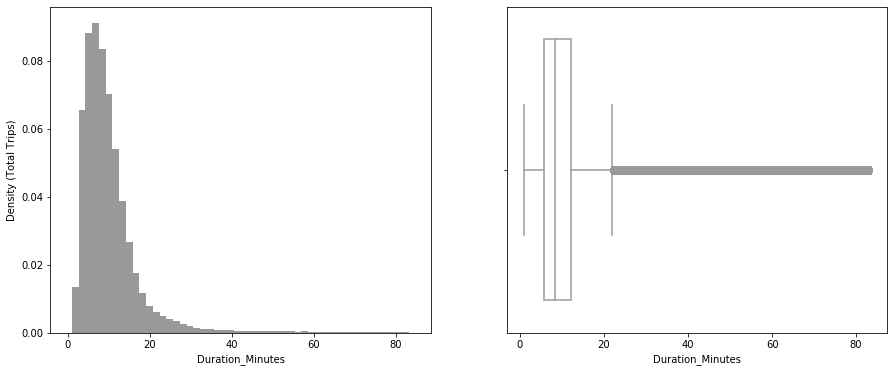

In [83]:
# reexamine distribution

fig, ax= plt.subplots(1,2,figsize=[15,6])

sns.distplot(total_trips_capped['Duration_Minutes'], kde=True, color=(0.0, 0.0, 0.0, 0.0),ax=ax[0])
ax[0].set_ylabel('Density (Total Trips)')
sns.boxplot(total_trips_capped['Duration_Minutes'], ax=ax[1], color='white')
ax[1].set_xlabel('Duration_Minutes')

plt.savefig('Distribution_duration.png')

plt.show()

### Visualize distribution of activity per day of the week, for customers and subscribers

In [84]:
# Define some helper functions for graphs and variables for the graphs

palette={'Customer':(0.9, 0.0, 0.0), 'Subscriber':(0.0, 0.9, 0.0)}

def plotb(x,y,data,ax):
    
    g=sns.barplot(x=x, y=y, hue='subscription_type', data=data,palette=palette, ax=ax)
    return g



In [85]:
total_trips_capped_day = total_trips_capped.groupby(['subscription_type']).agg(Number_of_Trips=('day_week','value_counts'))

In [86]:
total_trips_capped_day.reset_index(inplace=True)

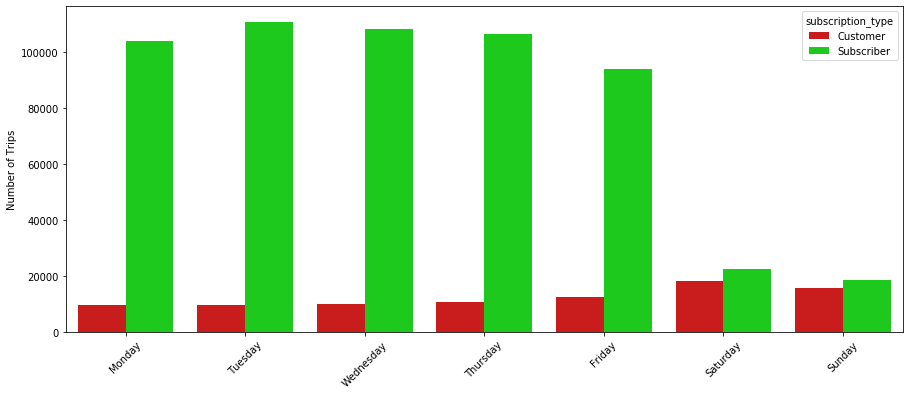

In [87]:
x=total_trips_capped_day['day_week']
y=total_trips_capped_day['Number_of_Trips']

fig= plt.figure(figsize=[15,6])
ax=sns.barplot(x=x,y=y,hue='subscription_type',palette=palette, data=total_trips_capped_day)
ax.set_xlabel((''))
ax.set_ylabel('Number of Trips')
ax.set_xticklabels(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], rotation=45)
plt.savefig('Distribution_trips_perDay.png')
plt.show()

### Visualize distribution of activity per month, for customers and subscribers

In [88]:
# aggregate for the weekday series

total_trips_capped_WD_month = total_trips_capped_WD.groupby(['subscription_type']).agg(Number_of_Trips=('Month','value_counts'))

In [89]:
total_trips_capped_WD_month.reset_index(inplace=True)
total_trips_capped_WD_month.head(1)

,subscription_type,Month,Number_of_Trips
0,Customer,9,7354


In [90]:
# aggregate for weekend series

total_trips_capped_WE_month = total_trips_capped_WE.groupby(['subscription_type']).agg(Number_of_Trips=('Month','value_counts'))

total_trips_capped_WE_month.reset_index(inplace=True)
total_trips_capped_WE_month.head(1)

,subscription_type,Month,Number_of_Trips
0,Customer,9,4443


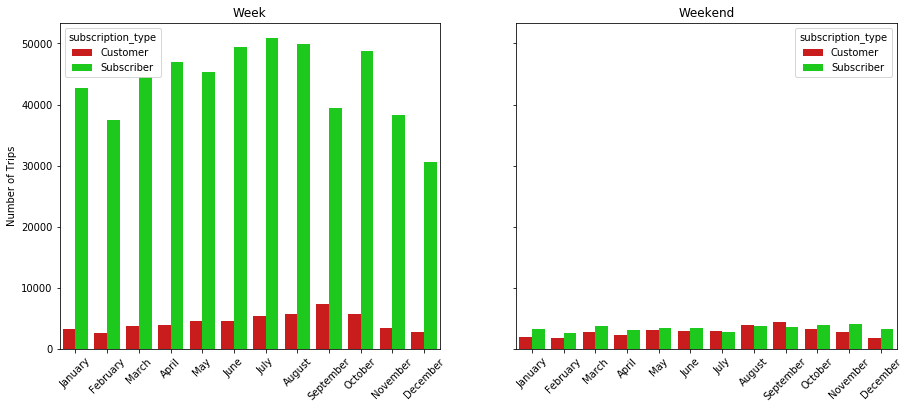

In [91]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=[15,6])
plotb(x='Month', y='Number_of_Trips',data=total_trips_capped_WD_month,ax=ax[0])
plotb(x='Month', y='Number_of_Trips',data=total_trips_capped_WE_month,ax=ax[1])
ax[0].set_xlabel((''))
ax[0].set_ylabel('Number of Trips')
ax[0].set_xticklabels(labels=['January','February','March','April','May','June','July','August','September','October',
'November','December'], rotation=45)
ax[0].set_title('Week')
ax[1].set_xlabel((''))
ax[1].set_ylabel((''))
ax[1].set_xticklabels(labels=['January','February','March','April','May','June','July','August','September','October',
'November','December'], rotation=45)
ax[1].set_title('Weekend')
plt.savefig('trips per month.png')
plt.show()

### Visualize distribution of activity per hour, for customers and subscribers

In [92]:
# aggregate for the weekday series

total_trips_capped_WD_hour = total_trips_capped_WD.groupby(['subscription_type']).agg(Number_of_Trips=('Hour','value_counts'))

In [93]:
total_trips_capped_WD_hour.reset_index(inplace=True)
total_trips_capped_WD_hour.head(1)

,subscription_type,Hour,Number_of_Trips
0,Customer,17,5067


In [94]:
# aggregate for the weekend series

total_trips_capped_WE_hour = total_trips_capped_WE.groupby(['subscription_type']).agg(Number_of_Trips=('Hour','value_counts'))

In [95]:
total_trips_capped_WE_hour.reset_index(inplace=True)
total_trips_capped_WE_hour.head(1)

,subscription_type,Hour,Number_of_Trips
0,Customer,13,3592


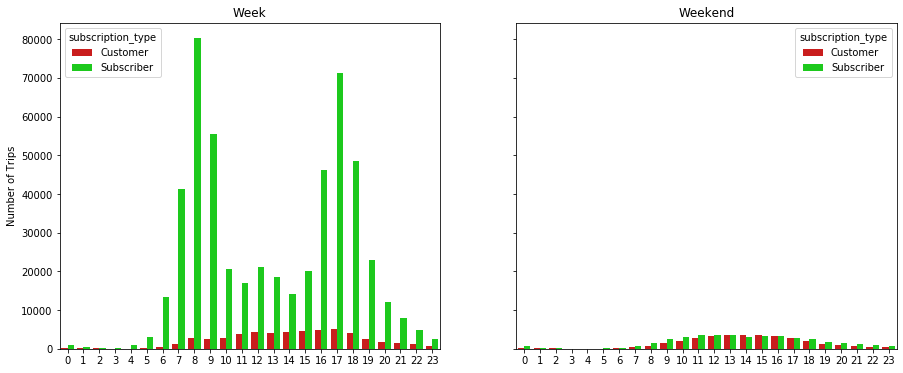

In [96]:
fig, ax = plt.subplots(1,2,sharex=True, sharey=True, figsize=[15,6])
plotb(x='Hour', y='Number_of_Trips',data=total_trips_capped_WD_hour,ax=ax[0])
plotb(x='Hour', y='Number_of_Trips',data=total_trips_capped_WE_hour,ax=ax[1])
ax[0].set_xlabel((''))
ax[0].set_ylabel('Number of Trips')

ax[0].set_title('Week')
ax[1].set_xlabel((''))
ax[1].set_ylabel((''))

ax[1].set_title('Weekend')
plt.savefig('trips per month.png')
plt.show()

### Visualize distribution of Duration of trips (in minutes) considering trips that started and ended in same station


In [97]:
# select those trips that started and ended in same station

total_trips_capped_equal = total_trips_capped[total_trips_capped['start_station_id']==total_trips_capped['end_station_id']]

In [98]:
total_trips_capped_equal.head(1)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,day_week,week_indicator,Month,Hour,year,Duration_Minutes
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,week,8,14,2013,1.05


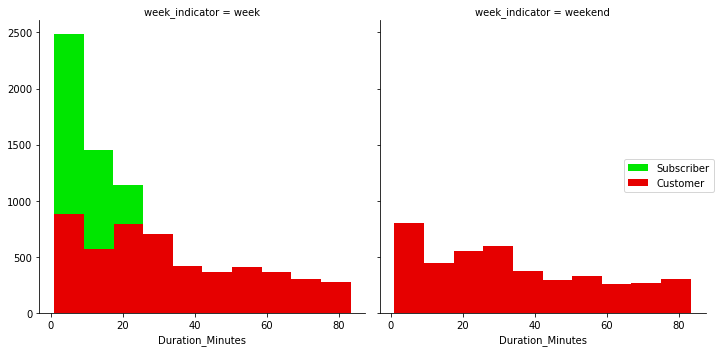

In [99]:
g = sns.FacetGrid(total_trips_capped_equal, col='week_indicator', hue='subscription_type', palette=palette, height=5)
g.map(plt.hist, 'Duration_Minutes')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center right', ncol=1)
#g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)
#g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
#g.fig.subplots_adjust(top=0.92, bottom=0.08)

plt.savefig('equal_stations_dis.png')

### Visualize distribution of Duration of trips for that started and ended in different stations

In [100]:
total_trips_capped_nequal = total_trips_capped[total_trips_capped['start_station_id']!=total_trips_capped['end_station_id']]

In [101]:
total_trips_capped_nequal.head(1)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,day_week,week_indicator,Month,Hour,year,Duration_Minutes
4,4299,83,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,3,week,8,12,2013,1.383333


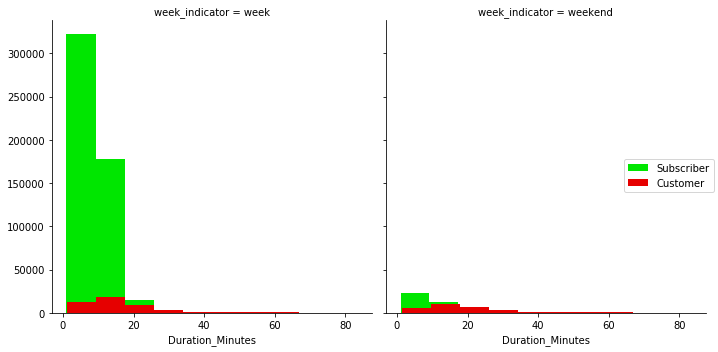

In [102]:
g = sns.FacetGrid(total_trips_capped_nequal, col='week_indicator', hue='subscription_type', palette=palette, height=5)
g.map(plt.hist, 'Duration_Minutes')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='center right', ncol=1)
#g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)
#g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
#g.fig.subplots_adjust(top=0.92, bottom=0.08)

plt.savefig('equal_stations_dis.png')

### Merge the data in station.csv with the trips data for the week and weekend time series

In [103]:
total_trips_capped_WD.head(1)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,day_week,week_indicator,Month,Hour,year,Duration_Minutes
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,week,8,14,2013,1.05


In [104]:
stations.head(1)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013


In [105]:
def merged_stations_trips():

    merge_WD = pd.merge(total_trips_capped_WD, stations, left_on='start_station_id', right_on='id', how='inner')

    merge_WE = pd.merge(total_trips_capped_WE, stations, left_on='start_station_id', right_on='id', how='inner')
    
    return merge_WD,merge_WE

In [106]:
merge_WD, merge_WE = merged_stations_trips()

### Visualize total trips per city and week/weekend

In [107]:
merge_WD_groupedbyCity = merge_WD.groupby(['subscription_type']).agg(Number_of_Trips=('city','value_counts'))

In [108]:
merge_WD_groupedbyCity.head(1)

,,Number_of_Trips
subscription_type,city,
Customer,San Francisco,47610


In [109]:
merge_WD_groupedbyCity.reset_index(inplace=True)

In [110]:
merge_WE_groupedbyCity = merge_WE.groupby(['subscription_type']).agg(Number_of_Trips=('city','value_counts'))

In [111]:
merge_WE_groupedbyCity.reset_index(inplace=True)

In [112]:
merge_WE_groupedbyCity.head(1)

,subscription_type,city,Number_of_Trips
0,Customer,San Francisco,30102


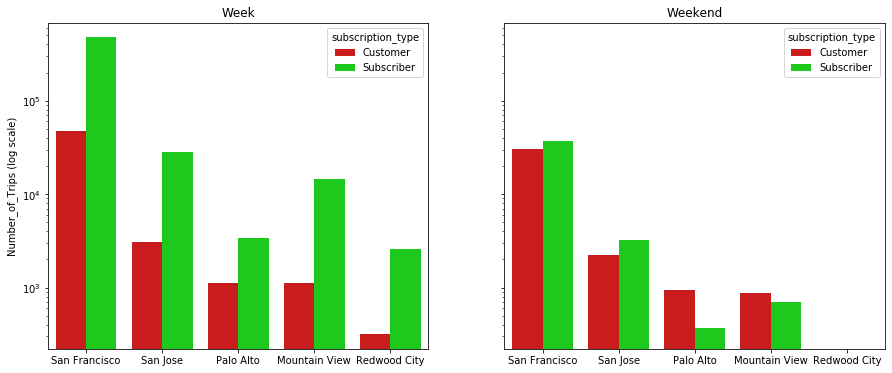

In [113]:
fig,ax=plt.subplots(1,2, sharex=True, sharey=True, figsize=[15,6])
plotb(x='city',y='Number_of_Trips', data=merge_WD_groupedbyCity,ax=ax[0])
plotb(x='city',y='Number_of_Trips', data=merge_WE_groupedbyCity,ax=ax[1])
ax[0].set_ylabel('Number_of_Trips (log scale)')
ax[0].set_xlabel((''))
ax[0].set_yscale('log')
ax[0].set_title('Week')
ax[1].set_title('Weekend')
ax[1].set_xlabel((''))
ax[1].set_ylabel((''))
ax[1].set_yscale('log')
plt.savefig('cities')

plt.show()

### Visualize activity within the cities using heatmaps

In [114]:
# Redefine labels of San Francisco stations

labels=['2nd at Folsom','2nd at South Park','2nd at Townsend','5th at Howard','Beale at Market',
'Broadway at Battery St',
 'Civic Center BART',
 'Clay at Battery',
 'Commercial Montgomery',
 'Davis at Jackson',
 'Embarcadero at Bryant',
 'Embarcadero at Folsom',
 'Embarcadero at Sansome',
 'Embarcadero at Vallejo',
 'Golden Gate at Polk',
 'Grant Av at Columbus Av',
 'Harry Bridges Plaza',
 'Howard at 2nd',
 'Market at 10th',
 'Market at 4th',
 'Market at Sansome',
 'Mechanics Plaza',
 'Post at Kearney',
 'Post at Kearny',
 'Powell Street BART',
 'Powell at Post',
 'Redwood City Station',
 'San Francisco Caltrain',
 'San Francisco Caltrain 2',
 'San Francisco City Hall',
 'South Van Ness at Market',
 'Spear at Folsom',
 'Steuart at Market',
 'Temporary Transbay Terminal',
 'Townsend at 7th',
 'Washington at Kearney',
 'Washington at Kearny',
 'Yerba Buena Center of the Arts']

##### San Francisco

In [115]:
## weekday san francisco

merged_sf_WD = merge_WD[merge_WD['city']=='San Francisco']

merged_sf_WD_grouped=merged_sf_WD.groupby(by=['name'],).agg(Number_of_Trips=('subscription_type','value_counts'))

merged_sf_WD_grouped=merged_sf_WD_grouped.unstack(['subscription_type'])


In [116]:
merged_sf_WD_grouped.head(1)

Number_of_Trips           
subscription_type        Customer Subscriber
name                                        
2nd at Folsom                 711      13860

In [117]:
## weekend san francisco

merged_sf_WE = merge_WE[merge_WE['city']=='San Francisco']

merged_sf_WE_grouped=merged_sf_WE.groupby(by=['name']).agg(Number_of_Trips=('subscription_type','value_counts'))

merged_sf_WE_grouped=merged_sf_WE_grouped.unstack(['subscription_type'])

In [118]:
merged_sf_WE_grouped.head(10)

Number_of_Trips           
subscription_type                        Customer Subscriber
name                                                        
2nd at Folsom                                 376        836
2nd at South Park                             461       1016
2nd at Townsend                              1220       1763
5th at Howard                                 577       1082
Beale at Market                               471        647
Broadway St at Battery St                     264        481
Civic Center BART (7th at Market)             726       1191
Clay at Battery                               551        445
Commercial at Montgomery                      348        604
Davis at Jackson                              332        957

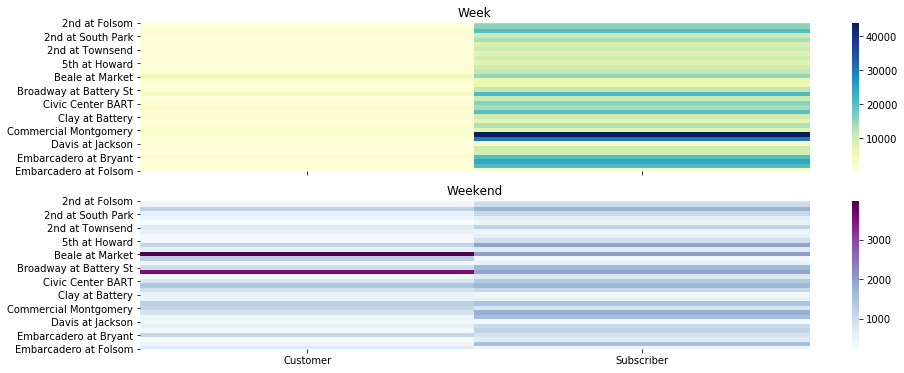

In [119]:
## san francisco weekday/weekend heatmap showing starting station,customer and subscriber

fig, ax= plt.subplots(2,1, figsize=[15,6])

sns.heatmap(merged_sf_WD_grouped, ax=ax[0],cmap="YlGnBu")
ax[0].set_ylabel((''))
ax[0].set_xlabel((''))
ax[0].xaxis.set_ticklabels([])
ax[0].set_title('Week')
ax[0].set_yticklabels(labels=labels)

sns.heatmap(merged_sf_WE_grouped, ax=ax[1],cmap="BuPu")
ax[1].set_ylabel((''))
ax[1].set_xlabel((''))
ax[1].xaxis.set_ticklabels(['Customer','Subscriber'])
ax[1].set_title('Weekend')
ax[1].set_yticklabels(labels=labels)

plt.savefig('heatmap_sanfrancisco')

plt.show()

In [120]:
# san francisco week for customers

In [121]:
merged_sf_WD_c= merged_sf_WD[merged_sf_WD['subscription_type']=='Customer']

In [122]:
merged_sf_WD_c.head(1)

,id_x,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,...,Hour,year,Duration_Minutes,id_y,name,lat,long,dock_count,city,installation_date
11,4808,572,2013-08-29 17:27:00,South Van Ness at Market,66,2013-08-29 17:37:00,Golden Gate at Polk,59,375,Customer,...,17,2013,9.533333,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,8/23/2013


In [123]:
merged_sf_WD_c_gr= merged_sf_WD_c.groupby(['start_station_name']).agg(Number_Trips=('end_station_name','value_counts'))

In [124]:
merged_sf_WD_c_gr_us=merged_sf_WD_c_gr.unstack()

In [125]:
array_column= merged_sf_WD_c_gr_us.columns.values


In [126]:
#labels=[value[1] for value in array_column]

#labels

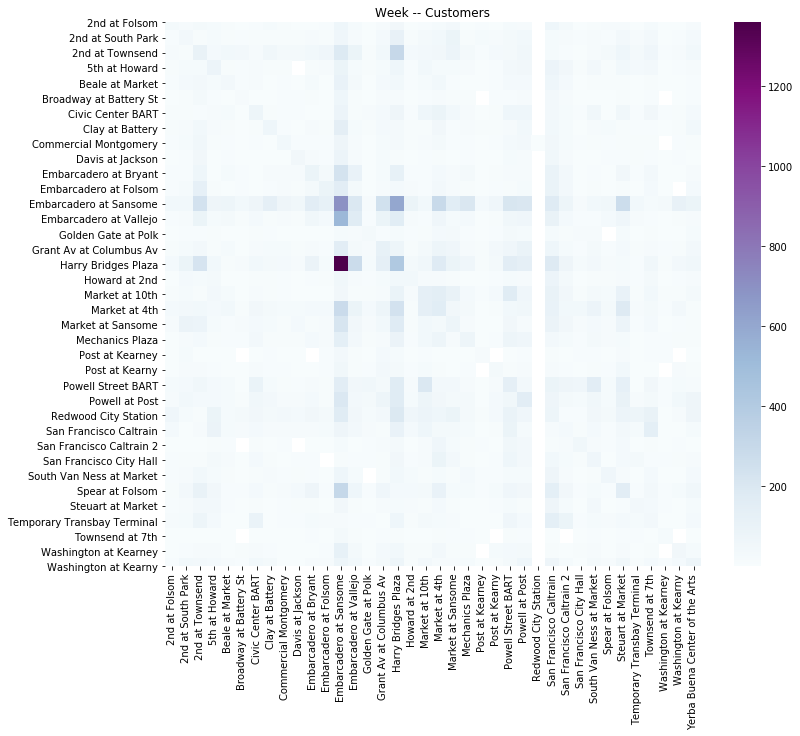

In [127]:
fig = plt.figure(figsize=[12,10])

g=sns.heatmap(merged_sf_WD_c_gr_us,cmap="BuPu")
g.set_ylabel((''))
g.set_xlabel((''))
#g.xaxis.set_ticklabels([])
g.set_title('Week -- Customers')
g.set_yticklabels(labels=labels)
g.set_xticklabels(labels=labels)

plt.savefig('heatmap_SF_stations_C.png')

plt.show()


In [128]:
# san francisco week for subscribers

merged_sf_WD_s= merged_sf_WD[merged_sf_WD['subscription_type']=='Subscriber']

merged_sf_WD_s_gr= merged_sf_WD_s.groupby(['start_station_name']).agg(Number_Trips=('end_station_name','value_counts'))

merged_sf_WD_s_gr_us=merged_sf_WD_s_gr.unstack()

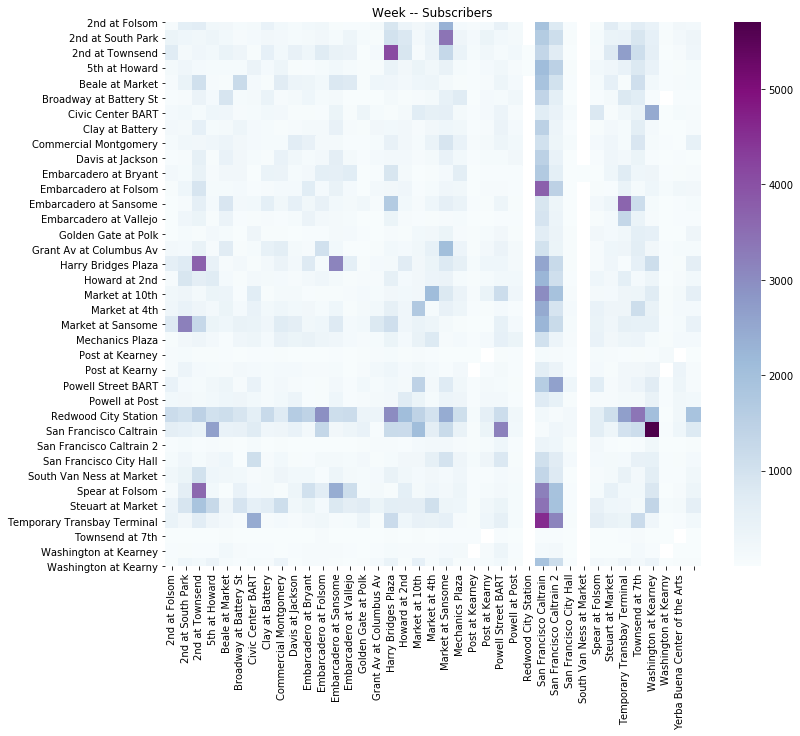

In [129]:
fig = plt.figure(figsize=[12,10])

g=sns.heatmap(merged_sf_WD_s_gr_us,cmap="BuPu")
g.set_ylabel((''))
g.set_xlabel((''))
#g.xaxis.set_ticklabels([])
g.set_title('Week -- Subscribers')
g.set_yticklabels(labels=labels)
g.set_xticklabels(labels=labels)

plt.savefig('heatmap_SF_stations_S.png')

plt.show()

### Visualize distribution of distances    

In [130]:
# We would like to examine the distribution of the distances that the riders cover. We will
# define the distance as the linear distance between departure station and arrival station

In [131]:
total_trips_capped.head(1)

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,day_week,week_indicator,Month,Hour,year,Duration_Minutes
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,week,8,14,2013,1.05


In [132]:
## generate a dataframe with latitudes and longitudes for starting and ending points

def lat_long():
    
    # merge_1 in order to get starting lat and lon
    merge_1 = pd.merge(total_trips_capped, stations, left_on='start_station_id', right_on='id', how='inner')
    
    # rename columns
    merge_1.rename(columns={'lat':'lat_start','long':'lon_start'},inplace=True)
    
    # keep only necessary columns
    merge_1 = merge_1[['lat_start','lon_start','end_station_id']]
    
    # merge_2 in order to get ending lat and lon
    merge_2 =pd.merge(merge_1, stations, left_on='end_station_id',right_on='id', how='inner')
    
    # rename columns
    merge_2.rename(columns={'lat':'lat_end','long':'lon_end'}, inplace=True)
    
    # keep only necessary columns
    merge_2 = merge_2[['lat_start','lon_start','lat_end','lon_end']]
    
    return merge_2   

In [133]:
merge_2 = lat_long()

In [134]:
merge_2.head(1)

,lat_start,lon_start,lat_end,lon_end
0,37.774814,-122.418954,37.774814,-122.418954


In [135]:
## Loop to calculate distances:

from math import sin, cos, sqrt, atan2, radians

distance=[]

for value in range(0,len(merge_2.index)):

        # approximate radius of earth in km
        R = 6373.0

        lat1 = radians(merge_2['lat_start'][value])
        lon1 = radians(merge_2['lon_start'][value])
        lat2 = radians(merge_2['lat_end'][value])
        lon2 = radians(merge_2['lon_end'][value])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        dist = R * c
        
        distance.append(dist)   

In [136]:
# Filter out values of 0 distance as they represent same starting and ending station

distance_filtered = list(filter(lambda x: x != 0, distance))

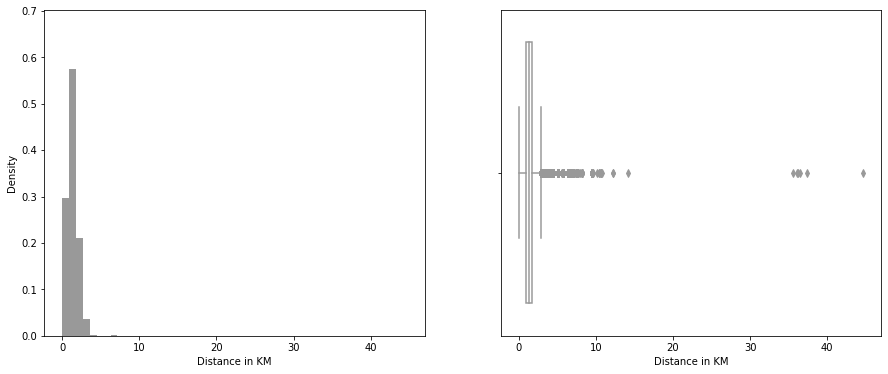

In [137]:
## Distribution of trips distances (estimated as distance between departing and ending station)

fig,ax = plt.subplots(1,2,sharex=True,figsize=[15,6])

sns.distplot(distance_filtered, kde=True, ax=ax[0], color=(0.0, 0.0, 0.0, 0.0))
sns.boxplot(distance_filtered, ax=ax[1], color='white')
ax[0].set_xlabel('Distance in KM')
ax[0].set_ylabel('Density')
ax[1].set_xlabel('Distance in KM')


plt.savefig('distance_km.png')
plt.show()


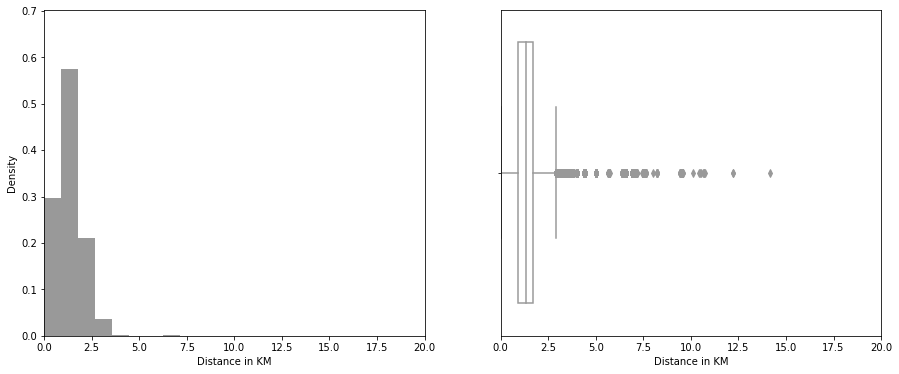

In [138]:
## Distribution of trips distances (estimated as distance between departing and ending station)
## Capped at 20 km

fig,ax = plt.subplots(1,2,sharex=True,figsize=[15,6])

sns.distplot(distance_filtered, kde=True, ax=ax[0], color=(0.0, 0.0, 0.0, 0.0))
sns.boxplot(distance_filtered, ax=ax[1], color='white')
ax[0].set_xlabel('Distance in KM')
ax[0].set_xlim(0,20)
ax[0].set_ylabel('Density')
ax[1].set_xlabel('Distance in KM')


plt.savefig('distance_20km.png')
plt.show()